# development work on "shifty"
 - 20191106
 - Helpful to have a notebook around for playing with functionality 

#### Reminder of the contents / types generated when reading a fits file with astropy ...

In [23]:
import astropy
from astropy.io import fits
import numpy as np 
import textwrap
import matplotlib.pyplot as plt
import os, sys 
import importlib
import glob
from tqdm import tqdm


from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.wcs import WCS

import fitsio


# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import known
import downloader

importlib.reload(known)
importlib.reload(downloader)



<module 'downloader' from '/Users/matthewjohnpayne/Envs/shifty/shifty/downloader.py'>

# TESS Ninja ...

##### Some notes on which camera/ccd/etc we expect Sedna to be in 
 - These came from inputing 57.136 7.6549 into lightkurve's tess-cut/tess-search function 

In [2]:
# Some notes on which camera/ccd/etc we expect Sedna to be in 
# - These came from inputing 57.136 7.6549 into lightkurve's tess-cut/tess-search function 
camera = 1 
ccd = 4
col, row = 1550, 1101

##### Download the FFIs for the specific sector 

#### Look at the position of a known  object (Sedna) 

### ** WHY DOES IT SEEM AS THOUGH THERE IS A VERY SLIGHT "KINK" IN THE RA,DEC OF SEDNA HALF-WAY THROUGH THE SECTOR ? **

2458436.5 57.1364 7.65498
2458436.541666667 57.13601 7.65487



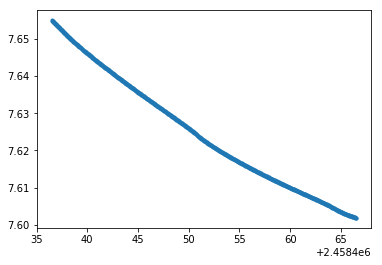

In [3]:
importlib.reload(known)
K = known.Known()

# These are the values from JPL at hourly intervals
JD_, RA_, Dec_  = K._radec_for_sedna()
for t,r,d in zip(JD_[:2], RA_[:2], Dec_[:2]):
    print(t,r,d)
print()

# Plot the positions across the course of the November 2019 (Sector-5) period  
RA_, Dec_ = K._interpolate_radec_for_sedna(JD_)
#plt.plot(JD_, RA_ , '.')
plt.plot(JD_, Dec_ , '.')

## How to read and stack FFI images?
 - DEVELOPMENTAL CODE FROM GEERT (FEB 9TH & 10TH)

In [133]:
class TessLoader():
    """Load a patch of FFI data from TESS FFI files.
    """
    
    # TESS Cameras provide 2048x2048 science pixels
    # with the following x/y coordinate ranges:
    XRANGE = (44, 2092)
    YRANGE = (0, 2048)
    
    def __init__(self, filenames):
        self.filenames = filenames

    def _patch_to_limits(self, patch=1, patchsize=512):
        """Returns the corners (xmin, xmax, ymin, ymax) of a patch."""
        patch_x = int(patch % np.floor(2048 / patchsize))
        patch_y = int(np.floor((patch * patchsize) / 2048))
        return (self.XRANGE[0] + patch_x * patchsize,
                self.XRANGE[0] + (patch_x + 1) * patchsize,
                self.YRANGE[0] + patch_y * patchsize,
                self.YRANGE[0] + (patch_y + 1) * patchsize)
        
    def get_patch(self, patch=1, patchsize=512):
        """Returns an `ImageData` object containing the pixel data in a patch."""
        xmin, xmax, ymin, ymax = self._patch_to_limits(patch=patch, patchsize=patchsize)        
        images = np.empty((len(self.filenames), ymax-ymin, xmax-xmin))
        headers = []
        for idx, fn in tqdm(enumerate(self.filenames), total=len(self.filenames), desc='Reading FFIs'):
            with fitsio.FITS(fn) as fts:
                images[idx] = fts[1][ymin:ymax, xmin:xmax]
                headers.append(fts[1].read_header())
        return ImageData(images, headers)


class ImageData():
    """Holds a set of imaging data to stack."""
    def __init__(self, data, headers=None):
        """
        Parameters
        ----------
        data : ndarray
            3D numpy array of shape (images, columns, rows)
        headers : list of headers
            Headers associated with each image.
        """
        self.data = data
        self.headers = headers
    
    def __len__(self):
        return self.data.shape[0]
    
    def stack(self, shifts=None):
        """
        Parameters
        ----------
        shifts : tuple of tuples (x, y)
            e.g., ((0,0), (-1,3), ...)
        """
        if shifts is None:
            shifts = zip(np.zeros(len(self)), np.zeros(len(self)))

        def z2n(val):
            """Converts 0 to None, which we need for indexing below."""
            if val == 0:
                return None
            return val

        stack = np.zeros(self.data.shape[1:])
        for idx, shift in enumerate(shifts):
            if (shift[0] >= 0) and (shift[1] >= 0):
                stack[shift[1]:, shift[0]:] += self.data[idx, :z2n(-shift[1]), :z2n(-shift[0])]
            elif (shift[0] >= 0) and (shift[1] < 0):
                stack[:-shift[1], shift[0]:] += self.data[idx, shift[1]:, :z2n(-shift[0])]
            elif (shift[0] < 0) and (shift[1] < 0):
                stack[:-shift[1], :-shift[0]] += self.data[idx, shift[1]:, shift[0]:]
            elif (shift[0] < 0) and (shift[1] >= 0):
                stack[shift[1]:, :-shift[0]] += self.data[idx, :z2n(-shift[1]), shift[0]:]
        return stack        
    
    def median_template(self,):
        '''
            Make a simple median of a stack
        '''
        return np.median(self.data, axis=0)
        
    def subtract(self, template):
        '''
            Subtract the supplied template from each element of the data 
        '''
        return self.data - template 

In [5]:
def get_sedna_shifts(headers):
    x, y = [], []
    ralist, declist = [], []
    times = []
    for hdr in headers:
        jd = hdr['BJDREFI'] + hdr['TSTART']
        ra, dec = known.Known()._interpolate_radec_for_sedna(jd)
        crd = SkyCoord(ra, dec, unit='deg')
        pixel = WCS(hdr).world_to_pixel(crd)
        x.append(int(pixel[0]))
        y.append(int(pixel[1]))
        ralist.append(ra)
        declist.append(dec)
        times.append(jd)
    return np.array(tuple(zip(x, y))), np.array(tuple(zip(ralist, declist))), times

##### Open the available fits -files for sectorNumber, cameraNumber, chipNumber = 5,1,4


In [124]:
# Define the filenames 
PATH = "/Users/matthewjohnpayne/.shifty_data/tess/5/1/4/"
filenames= sorted(glob.glob(PATH + '/*s0005-1-4*')[:-1])
len(filenames)

229

In [134]:
# load the data 
T = TessLoader(filenames)
data = T.get_patch(10)
xmin, xmax, ymin, ymax = T._patch_to_limits( patch=10, patchsize=512)
print( 'xmin, xmax, ymin, ymax = ' , xmin, xmax, ymin, ymax )

Reading FFIs: 100%|██████████| 229/229 [00:03<00:00, 75.52it/s]

xmin, xmax, ymin, ymax =  1068 1580 1024 1536


In [135]:
# get shifts from sedna positions
shifts, radec, times = get_sedna_shifts(data.headers)
sedna_x0,sedna_y0 = shifts[0]
print('sedna_x0, sedna_y0 = ', sedna_x0, sedna_y0)
shifts -= shifts[0]
print(shifts[-1])

print(shifts[:3], radec[:3], times[:3])
print(len(shifts ))

sedna_x0, sedna_y0 =  1541 1102
[15  0]
[[0 0]
 [0 0]
 [0 0]] [[57.12230937  7.65084373]
 [57.12210437  7.65078873]
 [57.12189936  7.65073373]] [2458438.006161625, 2458438.0269953073, 2458438.047828989]
229


 sedna_patch_x0, sedna_patch_y0 = 473 78
4.042920704005934 0.341380557120593


(58, 98)

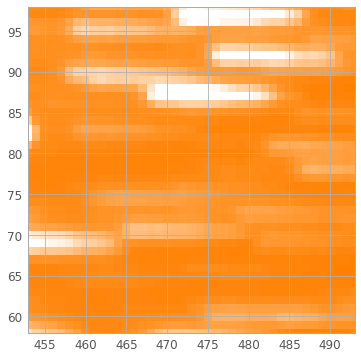

In [136]:
# expected location of sedna in this patch 
sedna_patch_x0, sedna_patch_y0 = sedna_x0 - xmin, sedna_y0 - ymin
print(' sedna_patch_x0, sedna_patch_y0 =', sedna_patch_x0, sedna_patch_y0 )

# plot the shifted data 
mystack = np.log10(data.stack(shifts))
print(np.nanmin(mystack), np.nanmax(mystack)*0.05)
plt.imshow(mystack , vmin=4.1, vmax=4.7)

s = 20
plt.xlim(sedna_patch_x0 - s, sedna_patch_x0 + s )
plt.ylim(sedna_patch_y0 - s, sedna_patch_y0 + s )


In [137]:
s = data.stack(shifts)
t = data.median_template()
s.shape , t.shape

((512, 512), (512, 512))

(58, 98)

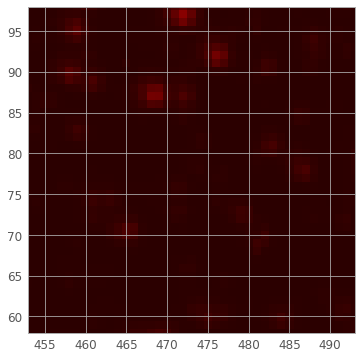

In [138]:
mn, mx = np.nanmin(t), np.nanmax(t)
plt.imshow( np.log10(t) )#, vmin=mn, vmax=mx)

s = 20
plt.xlim(sedna_patch_x0 - s, sedna_patch_x0 + s )
plt.ylim(sedna_patch_y0 - s, sedna_patch_y0 + s )


-3430.7265625 3611.2578125


/Users/matthewjohnpayne/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/matthewjohnpayne/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10


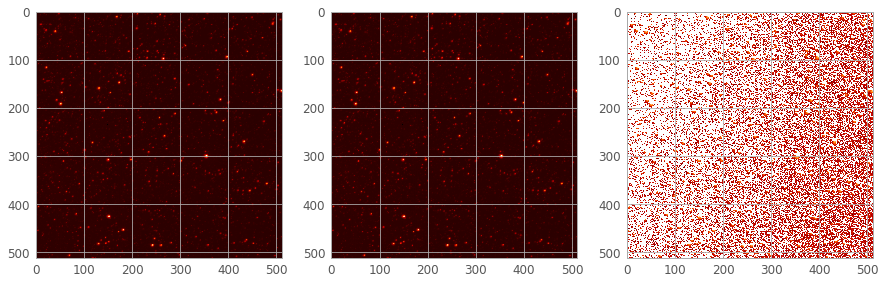

In [148]:
# subtract the template from the data 
subtracted = data.subtract(t)

# Make comparison plots 
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
fig, ax = plt.subplots(1, 3,figsize=(15,5))

sliceNumber = 50 

# single slice from data 
ax[0].imshow( np.log10( data.data[sliceNumber]) )#, vmin=mn, vmax=mx)

# template
ax[1].imshow( np.log10( t ) )#, vmin=mn, vmax=mx)

# single slice from subtracted 
mn,mx = np.nanmin(subtracted[sliceNumber]), np.nanmax(subtracted[sliceNumber])
print(mn, mx)
ax[2].imshow( np.log10( subtracted[sliceNumber]) )#, vmin=mn, vmax=mx)


# Eleanor ... 
# - Steps for cleaning/detrending/...
Clip peaks
PCA on remaining pixels 
Background model 
Interpolate model across masked star pixels 

Are there issues with doing larger patches? Would one have to think about using a larger number of times to allow for a greater range of correlated pixels for large scale patterns 

Some small issues with successful subtraction 

Problem with asteroids crossing FoV/aperture, creating structure that PCAs can't really handle: throw-away into "bad pixels 

# Old (2019) ...

In [49]:
filepath1 = '/Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292095940-s0004-1-1-0124-s_ffic.fits'
filepath2 = '/Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292102940-s0004-1-1-0124-s_ffic.fits'
filepath3 = '/Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292105940-s0004-1-1-0124-s_ffic.fits'

# set up a new fits-file to write to...
# https://astropy-cjhang.readthedocs.io/en/latest/generated/examples/io/create-mef.html#sphx-glr-generated-examples-io-create-mef-py
new_hdul = fits.HDUList([fits.PrimaryHDU()])
test_filepath = '/Users/matthewjohnpayne/Envs/shifty/shifty/MJPtest.fits'
new_hdul.writeto(test_filepath, overwrite=True)

# add header & image-data to a new file 
for filepath in [filepath1, filepath2, filepath3]:
    with fits.open(filepath) as hdul:
        print('\n ----- \n ')
        # examine contents
        hdul.info()
        # create an ImageHDU object 
        IHDU = fits.ImageHDU()
        
        # make ImageHDU have header & data from the file we are reading 
        # https://astropy-cjhang.readthedocs.io/en/latest/io/fits/api/images.html#astropy.io.fits.ImageHDU
        IHDU.header = hdul[1].header
        IHDU.data   = hdul[1].data
        
        # change the name in the header (to record where the data came from)
        IHDU.header['EXTNAME'] = os.path.split(filepath)[1]
        
        # add to multi-file 
        new_hdul.append(IHDU)
        del IHDU
        
# now set up a fits-table and that to the overall file ..
# https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file

a1 = np.array(['NGC1001', 'NGC1002', 'NGC1003'])
a2 = np.array([11.1, 12.3, 15.2])
hdu_table = fits.BinTableHDU.from_columns(
    [fits.Column(name='target', format='20A', array=a1),
     fits.Column(name='V_mag', format='E', array=a2)],
    name = 'Theta'
)
new_hdul.append(hdu_table)


# write the full HDUlist to file 
new_hdul.writeto(test_filepath, overwrite=True)

# close it all down ... 
new_hdul.close()
print('...........')
new_hdul.info()
del new_hdul



 ----- 
 
Filename: /Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292095940-s0004-1-1-0124-s_ffic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  CAMERA.CCD 1.1 cal    1 ImageHDU       183   (2136, 2078)   float32   
  2  CAMERA.CCD 1.1 uncert    1 ImageHDU       183   (2136, 2078)   float32   

 ----- 
 
Filename: /Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292102940-s0004-1-1-0124-s_ffic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  CAMERA.CCD 1.1 cal    1 ImageHDU       183   (2136, 2078)   float32   
  2  CAMERA.CCD 1.1 uncert    1 ImageHDU       183   (2136, 2078)   float32   

 ----- 
 
Filename: /Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292105940-s0004-1-1-0124-s_ffic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  CAME

In [51]:
with fits.open(test_filepath) as hdul:
    # examine contents
    for item in hdul:
        print(item,  item.name )
        print('\t\t', isinstance(item,astropy.io.fits.hdu.image.ImageHDU))
        print('\t\t', isinstance(item,astropy.io.fits.hdu.table.BinTableHDU))
            


<astropy.io.fits.hdu.image.PrimaryHDU object at 0x11acc1ba8> PRIMARY
		 False
		 False
<astropy.io.fits.hdu.image.ImageHDU object at 0x11aceba20> tess2018292095940-s0004-1-1-0124-s_ffic.fits
		 True
		 False
<astropy.io.fits.hdu.image.ImageHDU object at 0x118aa8358> tess2018292102940-s0004-1-1-0124-s_ffic.fits
		 True
		 False
<astropy.io.fits.hdu.image.ImageHDU object at 0x118ac58d0> tess2018292105940-s0004-1-1-0124-s_ffic.fits
		 True
		 False
<astropy.io.fits.hdu.table.BinTableHDU object at 0x11acddf98> THETA
		 False
		 True


In [79]:
with fits.open(filepath1) as hdul:
    # examine contents
    hdul.info()

Filename: /Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292095940-s0004-1-1-0124-s_ffic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  CAMERA.CCD 1.1 cal    1 ImageHDU       183   (2136, 2078)   float32   
  2  CAMERA.CCD 1.1 uncert    1 ImageHDU       183   (2136, 2078)   float32   


In [83]:
with fits.open(filepath1) as hdul:
    for n in range(3):
        print('\n ------- %d -------\n' % n )
        print(type(obj[n]))
        print('%d: header:\n%r' % (n, hdul[n].header ) )
        print()
        print('%d: data:\n%r'   % (n, hdul[n].data))


 ------- 0 -------

<class 'astropy.io.fits.hdu.image.PrimaryHDU'>
0: header:
SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2018-11-14'         / file creation date.                            
TSTART  =    1410.917241951712 / observation start time in TJD                  
TSTOP   =    1410.938075279943

In [8]:
np.shape(obj[0].data), np.shape(obj[1].data), np.shape(obj[2].data)

((), (2078, 2136), (2078, 2136))

In [9]:
obj[1].data, obj[2].data

(array([[ 0.18281528,  0.07671411,  0.1595356 , ...,  0.00712733,
          0.01205946,  0.01674499],
        [ 0.18610774,  0.1343039 ,  0.20602259, ...,  0.04289078,
          0.01402684, -0.02938142],
        [ 0.13516839,  0.11913346,  0.093174  , ...,  0.00564221,
         -0.01113253, -0.03579868],
        ...,
        [ 0.04355072,  0.09161711,  0.06145985, ..., -0.0552806 ,
         -0.07920694, -0.02321625],
        [ 0.06528474,  0.06574507,  0.03978013, ..., -0.14580718,
         -0.11916818, -0.07846712],
        [ 0.09491035,  0.04110625,  0.05460934, ..., -0.07082231,
         -0.10658576, -0.05404757]], dtype=float32),
 array([[0.03711468, 0.03711468, 0.03711468, ..., 0.03711468, 0.03711468,
         0.03711468],
        [0.03711468, 0.03711468, 0.03711468, ..., 0.03711468, 0.03711468,
         0.03711468],
        [0.03711468, 0.03711468, 0.03711468, ..., 0.03711468, 0.03711468,
         0.03711468],
        ...,
        [0.03711468, 0.03711468, 0.03711468, ..., 0.03711

In [10]:
print(
    np.percentile(obj[1].data, [0,25,50,75,100] ),
    '\n',
    np.percentile(obj[2].data, [0,25,50,75,100] )
)

[-2.22786808e+01  1.06697315e+02  1.16617645e+02  1.25683958e+02
  1.20802109e+05] 
 [0.         0.32722809 0.34137806 0.35581718 9.54742813]


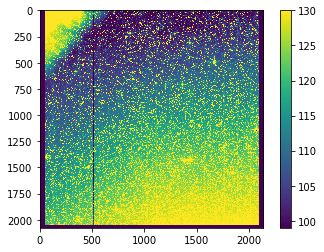

In [11]:
plt.imshow(obj[1].data, vmin=99.00, vmax=130.0)
plt.colorbar()


# Try using the methods and classes in "data" 

In [8]:
import importlib
import data 
import loader
import refcat

importlib.reload(data)
importlib.reload(loader)
importlib.reload(refcat)


<module 'refcat' from '/Users/matthewjohnpayne/Envs/shifty/shifty/refcat.py'>

### RefCat

In [9]:
# Test creation of RefCat object
# -----------------------------------------
RC = refcat.RefCat()
assert isinstance(RC , refcat.RefCat ), \
    'RefCat did not get created as expected'

# Need to create header, image_data to pass into *find_all_stars_on_image()*
# -----------------------------------------
T = loader.TESSImageLoader()
cpd = { _ : False for _ in ['mask' ,'subtract', 'bad_cad', 'scat', 'strap' ] }
IDS = T.get_image_data_set( **{'development' : True} , **cpd )

# run the find_all_stars_on_image script
# -----------------------------------------
ra, dec, pix, int_pix = RC.find_all_stars_on_image(IDS.headers[0] , IDS.data[0])



 ** WARNING: HARD-CODED MAG-LIMITS & SEARCH DIRECTORIES IN find_all_stars_on_image() ** 
(77083,) (77083,) (2, 77083) (2, 77083) (77083,)


In [58]:
IDS.data[0][:8,:8]

array([[ 0.18281528,  0.07671411,  0.1595356 ,  0.10309006,  0.01698597,
         0.03817223,  0.0556813 ,  0.02706397],
       [ 0.18610774,  0.1343039 ,  0.20602259,  0.13847977,  0.06199333,
         0.0915697 , -0.00290807,  0.02077714],
       [ 0.13516839,  0.11913346,  0.093174  ,  0.11689208,  0.12328742,
         0.0657897 ,  0.08897621,  0.03150589],
       [ 0.1402249 ,  0.11703839,  0.11080746,  0.09087068,  0.11995931,
         0.08071597,  0.07306568,  0.06468105],
       [ 0.19289267,  0.16575499,  0.0512418 ,  0.07076757,  0.07149095,
         0.09415685,  0.00437009,  0.00856788],
       [ 0.07289165,  0.13554072,  0.10612328,  0.06867194,  0.12218012,
         0.0802241 ,  0.08318338,  0.02546645],
       [ 0.16082911,  0.06561153,  0.06629107,  0.06263033,  0.09147235,
         0.0783748 ,  0.05370865,  0.05864079],
       [ 0.13283375,  0.12247079,  0.14287886,  0.10123522,  0.05237421,
         0.02004134,  0.04198933,  0.00671909]], dtype=float32)

Pixel value of sources ... translated by -1, -1 to match with positions in data-array from fits


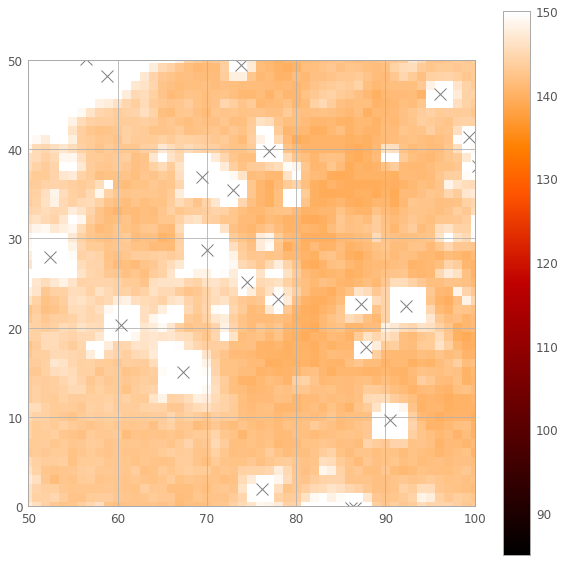

In [116]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
fig, ax = plt.subplots(1, 1,figsize=(10,10))

# plot the full FFI
cb = ax.imshow(IDS.data[0], vmin=85.00, vmax=150.)

# plot the sources from refcat
ax.plot(pix[0]-1, pix[1]-1, 'x', color='gray', alpha=2. , ms=12.)
xmin, xmax, ymin, ymax = 50,100,0,50
print('Pixel value of sources ... translated by -1, -1 to match with positions in data-array from fits')
for xp, yp in zip(pix[0], pix[1]):
    if xp > xmin and xp < xmax and yp > ymin and yp < ymax:
        pass #print(xp-1, yp-1)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
fig.colorbar(cb)


### Loader 

In [14]:
# create loader
T   = loader.TESSImageLoader()
# generate test ImageDataSet 
IDS = T.get_image_data_set( **{'development':True} )

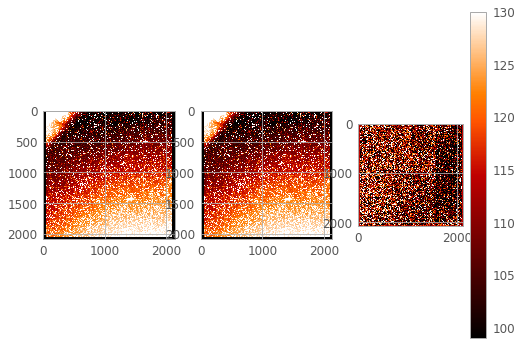

In [70]:
# plot some of the images 

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
fig, ax = plt.subplots(1, 3)
cb = ax[0].imshow(IDS.data[0], vmin=99.00, vmax=130.0)
ax[1].imshow(IDS.data[9], vmin=99.00, vmax=130.0)
ax[2].imshow(IDS.data[9]-IDS.data[0], vmin=-0.50, vmax=0.50)

fig.colorbar(cb)


# Times ...

In [19]:
# remindingmyself how astropy time works ...
time    = Time([2458337.8283571, 2458338.8283571], format='jd', scale='tdb')
time, type(time), len(time)
for _ in time: 
    print(_)
# time from IDS ...
for h in IDS.headers:
    print(h['BJDREFI'], h['BJDREFF'], h['TSTART'], h['TSTOP'])

2458337.8283571
2458338.8283571
2457000 0.0 1410.922486838214 1410.943320166445
2457000 0.0 1410.943320428612 1410.964153756844
2457000 0.0 1410.964154017614 1410.984987345844
2457000 0.0 1410.984987604751 1411.005820932982
2457000 0.0 1411.005821190027 1411.026654518258
2457000 0.0 1411.026654773441 1411.047488101672
2457000 0.0 1411.047488354992 1411.068321683223
2457000 0.0 1411.068321935145 1411.089155263375
2457000 0.0 1411.08915551297 1411.109988841201
2457000 0.0 1411.109989088933 1411.130822417164


# WCS ...

In [80]:
from astropy.wcs import WCS

x_ =  [0,   0, 2135, 2135 , 1045]
y_ =  [0, 2078,   0, 2078 , 1001]
print(
    np.array(WCS(IDS.headers[0]).all_pix2world(x_, y_, 1)).T
)
'''
CRVAL1  =  37.6041907846446150 / RA at CRPIX1, CRPIX2                           
CRVAL2  = -10.8342085542547150 / DEC at CRPIX1, CRPIX2                          
CRPIX1  =               1045.0 / X reference pixel                              
CRPIX2  =               1001.0 / Y reference pixel
NAXIS1  =                 2136 / length of first array dimension                
NAXIS2  =                 2078 / length of second array dimension              
'''

# get the dimensions of the data array 
print( IDS.data[0].shape )

# get the pixel value at x=5, y=2
# https://docs.astropy.org/en/stable/io/fits/usage/image.html
print(IDS.data[0][1, 4])   



[[ 33.75559012 -17.57932487]
 [ 30.0293247   -6.67716909]
 [ 45.53968634 -14.22924391]
 [ 41.71241072  -2.93171714]
 [ 37.60419078 -10.83420855]]
(2078, 2136)
0.06199333


In [219]:
# set up meshgrid 
xx, yy = np.meshgrid(range(np.shape(IDS.data[0])[1]), range(np.shape(IDS.data[0])[0]) )
print(np.shape(IDS.data[0])[1] , np.shape(IDS.data[0])[0], xx.shape, yy.shape )

# calculate & return the RA,DEC values for each pixel
RD  = WCS(IDS.headers[0]).all_pix2world(xx, yy, 1)

len(RD) , RD[0].shape

2136 2078 (2078, 2136) (2078, 2136)


(2, (2078, 2136))

In [218]:
np.array( [ [1,2,3], [2,3,4]] )

array([[1, 2, 3],
       [2, 3, 4]])

In [207]:
xx, yy = np.meshgrid(np.arange(IDS.data[0].shape[1]), np.arange(IDS.data[0].shape[0]))
print(np.shape(IDS.data[0])[1] , np.shape(IDS.data[0])[0], xx.shape, yy.shape )
pix = np.column_stack([xx.flatten(), yy.flatten()])
print(pix.shape)
world = WCS(IDS.headers[0]).wcs_pix2world(pix, 0)
print(world.shape)
ra = world[:, 0].reshape(np.shape(IDS.data[0]))
dec = world[:, 1].reshape(np.shape(IDS.data[0]))
print(ra.shape, dec.shape )

2136 2078 (2078, 2136) (2078, 2136)
(4438608, 2)
(4438608, 2)
(2078, 2136) (2078, 2136)


# RADEC-to-eqUV-to-ecUV

In [230]:
def _RADEC_to_unit( RA_, DEC_):
    '''
        This translates (RA,DEC)  into ...
        ...a unit vector (still in Equatorial coords)

        Inputs:
        -------
        RA_, DEC_ : iterables of floats
         - assumed in degrees & assumed in Equatorial coords

        Returns:
        --------
        UV_ : numpy array of shape == (3,len(RA_))
         - unit vector in Equatorial coords

    '''
    RA_, DEC_ = np.asarray(RA_), np.asarray(DEC_)

    x_ = np.cos(DEC_*np.pi/180.) * np.cos(RA_*np.pi/180.)
    y_ = np.cos(DEC_*np.pi/180.) * np.sin(RA_*np.pi/180.)
    z_ = np.sin(DEC_*np.pi/180.)
    return np.array([x_,y_,z_]).T

def rotate_matrix(ecl):
    ce = np.cos(ecl)
    se = np.sin(-ecl)
    rotmat = np.array([[1.0, 0.0, 0.0],
                       [0.0,  ce,  se],
                       [0.0, -se,  ce]])
    return rotmat
def equatorial_to_ecliptic( v):
    ecl = 84381.448*(1./3600)*np.pi/180.
    rot_mat = rotate_matrix( -ecl )
    return np.matmul(v, rot_mat.T)

In [337]:
from astropy.coordinates.representation import CartesianRepresentation,SphericalRepresentation, UnitSphericalRepresentation

ra = np.ones((4, ), dtype=float) * u.deg
dec = np.arange(1.,5.) * u.deg
distance = np.ones((4, ), dtype=float) * u.au
print('ra', ra)
print('dec', dec)

# old method 
eqUV = _RADEC_to_unit(ra, dec)
print('eqUV', eqUV)
ecUV = equatorial_to_ecliptic(eqUV)
print('ecUV',ecUV )

# new method 
c = SkyCoord(ra=ra, dec=dec, frame='icrs')
print('c', c, type(c))
eqUV = c.represent_as(UnitSphericalRepresentation).represent_as(CartesianRepresentation)
print('eqUV',eqUV, type(eqUV) )

backtoSky = eqUV.represent_as(UnitSphericalRepresentation)
print('backtoSky:',backtoSky )
backtoSky.representation_type = 'spherical'
print('backtoSky:',backtoSky )

bme = c.barycentricmeanecliptic
print('bme',bme)
ecUV = bme.represent_as(UnitSphericalRepresentation).represent_as(CartesianRepresentation)
print('ecUV =  ' , ecUV, type(ecUV))


CC=SkyCoord( *eqUV.get_xyz(), representation_type='cartesian')
print('CC:',CC, type(CC))


c = SkyCoord(x=1, y=2, z=3, representation_type='cartesian')
print(c, type(c)) 

c.representation_type = 'cylindrical'
print(c, type(c)) 

c.representation_type = 'spherical'
print(c, type(c)) 

c.representation_type = 'unitspherical'
print(c, type(c)) 



ra [1. 1. 1. 1.] deg
dec [1. 2. 3. 4.] deg
eqUV [[0.99969541 0.01744975 0.01745241]
 [0.99923861 0.01744177 0.0348995 ]
 [0.99847744 0.01742849 0.05233596]
 [0.99741212 0.01740989 0.06975647]]
ecUV [[0.99969541 0.022952   0.00907116]
 [0.99923861 0.02988474 0.02508172]
 [0.99847744 0.03680837 0.04108465]
 [0.99741212 0.0437208  0.05707506]]
c <SkyCoord (ICRS): (ra, dec) in deg
    [(1., 1.), (1., 2.), (1., 3.), (1., 4.)]> <class 'astropy.coordinates.sky_coordinate.SkyCoord'>
eqUV [(0.99969541, 0.01744975, 0.01745241),
 (0.99923861, 0.01744177, 0.0348995 ),
 (0.99847744, 0.01742849, 0.05233596),
 (0.99741212, 0.01740989, 0.06975647)]  <class 'astropy.coordinates.representation.CartesianRepresentation'>
backtoSky: [(0.01745329, 0.01745329), (0.01745329, 0.03490659),
 (0.01745329, 0.05235988), (0.01745329, 0.06981317)] rad
backtoSky: [(0.01745329, 0.01745329), (0.01745329, 0.03490659),
 (0.01745329, 0.05235988), (0.01745329, 0.06981317)] rad
bme <SkyCoord (BarycentricMeanEcliptic: equinox

True

# Rotation matrices ...

In [263]:
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product
#https://docs.astropy.org/en/stable/api/astropy.coordinates.CartesianRepresentation.html
#https://github.com/astropy/astropy/blob/master/astropy/coordinates/matrix_utilities.py

def calculate_rotation_matrix( ref_vec):
    ''' This routine returns the 3-D rotation matrix for the
        given reference vector.
        # rot_mat is a rotation matrix that converts from ecliptic
        # vectors to the projection coordinate system.
        # The projection coordinate system has z outward,
        # x parallel to increasing ecliptic longitude, and
        # y northward, making a right-handed system
        
        HeliocentricClusteringUtilitiesSingleDetections.py
        
        '''
    x_ref, y_ref, z_ref = ref_vec
    r = np.sqrt(x_ref*x_ref + y_ref*y_ref + z_ref*z_ref)
    lon0 = np.arctan2(y_ref, x_ref)
    lat0 = np.arcsin(z_ref/r)
    slon0 = np.sin(lon0)
    clon0 = np.cos(lon0)
    slat0 = np.sin(lat0)
    clat0 = np.cos(lat0)

    rot_mat = np.array([[-slon0, clon0, 0],
                        [-clon0*slat0, -slon0*slat0, clat0],
                        [clon0*clat0, slon0*clat0, slat0 ]])
    return rot_mat


In [316]:
vecs = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1],
    [1,1,1],
    ])

# set up rot-matrix using astropy utility
rotation = rotation_matrix(45 * u.deg, axis=[1,1,0])
print( rotation, type(rotation) )

rep = CartesianRepresentation(vecs[0])
print('rep', rep)

# set up rot-matrix using Holmans/Paynes func
rotation = calculate_rotation_matrix( CartesianRepresentation([0.99903862, 0.02908477, 0.02008163]).get_xyz()  )
print( rotation, type(rotation) )
print('rotated vectors ...\n', np.dot(rotation, vecs[0] ) )
print('rotated rep ...\n', rep.transform(rotation)  )


# now try operating on the ecUV from above 
print('ecUV ...\n' , ecUV, '\n',type(ecUV))
theta = ecUV[0].transform(rotation)
print()
print(theta, type(theta))

[[ 0.85355339  0.14644661 -0.5       ]
 [ 0.14644661  0.85355339  0.5       ]
 [ 0.5        -0.5         0.70710678]] <class 'astropy.units.quantity.Quantity'>
rep (1., 0., 0.) 
[[-2.91004290e-02  9.99576493e-01  0.00000000e+00]
 [-2.00798797e-02 -5.84580687e-04  9.99798208e-01]
 [ 9.99374786e-01  2.90945567e-02  2.00883873e-02]] <class 'numpy.ndarray'>
rotated vectors ...
 [-0.02910043 -0.02007988  0.99937479]
rotated rep ...
 (-0.02910043, -0.02007988, 0.99937479) 
ecUV ...
 [(0.99969541, 0.02295203, 0.00907106),
 (0.99923862, 0.02988477, 0.02508163),
 (0.99847744, 0.0368084 , 0.04108455),
 (0.99741212, 0.04372082, 0.05707496)]  
 <class 'astropy.coordinates.representation.CartesianRepresentation'>

(-0.00614925, -0.01101795, 0.99992039)  <class 'astropy.coordinates.representation.CartesianRepresentation'>


# Frames / Coords

In [11]:
ra = np.ones((4, ), dtype=float) * u.deg
dec = 2*np.ones((4, ), dtype=float) * u.deg
distance = np.ones((4, ), dtype=float) * u.au
test_icrs = ICRS(ra=ra, dec=dec, distance=distance)
bary_arr = test_icrs.transform_to(BarycentricMeanEcliptic)


In [12]:
ra, dec

(<Quantity [1., 1., 1., 1.] deg>, <Quantity [2., 2., 2., 2.] deg>)

In [13]:
test_icrs

<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    [(1., 2., 1.), (1., 2., 1.), (1., 2., 1.), (1., 2., 1.)]>

In [14]:
bary_arr

<BarycentricMeanEcliptic Coordinate (equinox=J2000.000): (lon, lat, distance) in (deg, deg, AU)
    [(1.71306506, 1.43722201, 1.), (1.71306506, 1.43722201, 1.),
     (1.71306506, 1.43722201, 1.), (1.71306506, 1.43722201, 1.)]>

In [32]:
T = data.TESSImageLoader()
HDUs = T._load_images('DEV')
r = [0.,90.,180., 270.,   0.,  0.,  90., 90., 0.,90.,180.,270.]
d = [0., 0.,  0.,   0., -90., 90., -90., 90.,45.,45., 45., 45.]
uv = data.ImageDataSet(HDUs,'C57')._RADEC_to_unit(r,d)
print(uv)
expected_uv = np.array(
[
    [1,0,0],
    [0,1,0],
    [-1,0,0],
    [0,-1,0],
    [0,0,-1],
    [0,0,1],
    [0,0,-1],
    [0,0,1],
    [1/np.sqrt(2),0,1/np.sqrt(2)],
    [0,1/np.sqrt(2),1/np.sqrt(2)],
    [-1/np.sqrt(2),0,1/np.sqrt(2)],
    [0,-1/np.sqrt(2),1/np.sqrt(2)],
]
)
assert np.allclose( uv , expected_uv) 


[  0.  90. 180. 270.   0.   0.  90.  90.   0.  90. 180. 270.] [  0.   0.   0.   0. -90.  90. -90.  90.  45.  45.  45.  45.]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.12323400e-17  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  1.22464680e-16  0.00000000e+00]
 [-1.83697020e-16 -1.00000000e+00  0.00000000e+00]
 [ 6.12323400e-17  0.00000000e+00 -1.00000000e+00]
 [ 6.12323400e-17  0.00000000e+00  1.00000000e+00]
 [ 3.74939946e-33  6.12323400e-17 -1.00000000e+00]
 [ 3.74939946e-33  6.12323400e-17  1.00000000e+00]
 [ 7.07106781e-01  0.00000000e+00  7.07106781e-01]
 [ 4.32978028e-17  7.07106781e-01  7.07106781e-01]
 [-7.07106781e-01  8.65956056e-17  7.07106781e-01]
 [-1.29893408e-16 -7.07106781e-01  7.07106781e-01]]


# Barycentric corrections
 - As expected, the barycentric correction changes by ~8mins when going from the ecliptic to the pole 

In [4]:
filepaths = ['/Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292095940-s0004-1-1-0124-s_ffic.fits', 
             '/Users/matthewjohnpayne/.shifty_data/tess/4/2/1/tess2018292095940-s0004-2-1-0124-s_ffic.fits',
             '/Users/matthewjohnpayne/.shifty_data/tess/4/3/1/tess2018292095940-s0004-3-1-0124-s_ffic.fits',
             '/Users/matthewjohnpayne/.shifty_data/tess/4/4/1/tess2018292095940-s0004-4-1-0124-s_ffic.fits']
for filepath in filepaths:
    obj = fits.open(filepath)
    print(filepath ,  obj[1].header['BARYCORR'])

/Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292095940-s0004-1-1-0124-s_ffic.fits 0.0052448865
/Users/matthewjohnpayne/.shifty_data/tess/4/2/1/tess2018292095940-s0004-2-1-0124-s_ffic.fits 0.0038683701
/Users/matthewjohnpayne/.shifty_data/tess/4/3/1/tess2018292095940-s0004-3-1-0124-s_ffic.fits 0.0026870426
/Users/matthewjohnpayne/.shifty_data/tess/4/4/1/tess2018292095940-s0004-4-1-0124-s_ffic.fits 0.00047090603


# PRFs

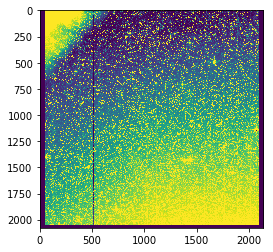

In [26]:
import importlib
import data 
import loader
import refcat

importlib.reload(data)
importlib.reload(loader)
importlib.reload(refcat)

import copy 

filepath = '/Users/matthewjohnpayne/.shifty_data/tess/4/1/1/tess2018292095940-s0004-1-1-0124-s_ffic.fits'
obj = fits.open(filepath)
imagedata = copy.deepcopy(obj)
plt.imshow(imagedata[1].data, vmin=99.00, vmax=130.0)


In [30]:
type(obj), type(imagedata)

(astropy.io.fits.hdu.hdulist.HDUList, astropy.io.fits.hdu.hdulist.HDUList)

astropy.io.fits.hdu.hdulist.HDUList

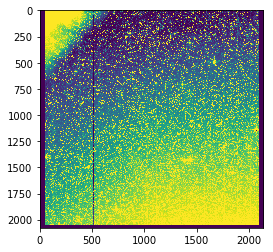

In [29]:
obj.close()
plt.imshow(imagedata[1].data, vmin=99.00, vmax=130.0)
type(imagedata)